In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai import *
from fastai.vision import *

# Get data
- Satellite imaging

In [0]:
!mkdir -p ~/.kaggle/
!mv kaggle.json ~/.kaggle

In [0]:
%pwd

'/content'

In [10]:
path = Path('amazon')
path.mkdir(exist_ok = True);path

PosixPath('amazon')

In [15]:
!kaggle competitions download -c planet-understanding-the-amazon-from-space -f train-jpg.tar.7z -p {path}
!kaggle competitions download -c planet-understanding-the-amazon-from-space -f train_v2.csv -p {path}
!unzip -q -n {path}/train_v2.csv.zip -d {path}

 98% 589M/600M [00:13<00:00, 47.8MB/s]
100% 600M/600M [00:13<00:00, 47.5MB/s]
  0% 0.00/159k [00:00<?, ?B/s]
100% 159k/159k [00:00<00:00, 50.0MB/s]


In [0]:
!7za -bd -y -so x {path}/train-jpg.tar.7z | tar xf - -C {path}

# Multiclass

In [18]:
df = pd.read_csv(path/'train_v2.csv')
df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [0]:
tfms = get_transforms(flip_vert = True, max_lighting = 0.1, max_zoom =1.05, max_warp = 0.)

In [0]:
np.random.seed(42)
src = (ImageList.from_csv(path, 'train_v2.csv', folder='train-jpg', suffix='.jpg')
       .split_by_rand_pct(0.2)
       .label_from_df(label_delim=' '))

In [0]:
data = (src.transform(tfms, size=128)
        .databunch().normalize(imagenet_stats))

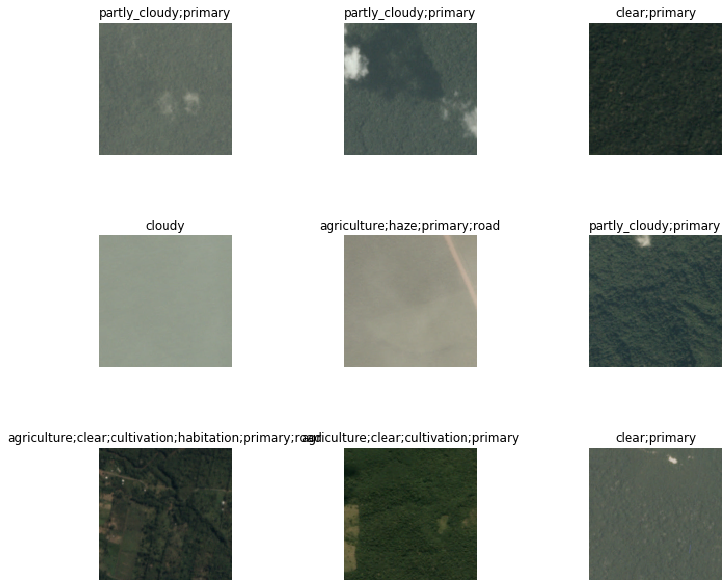

In [31]:
data.show_batch(rows = 3, figsize = (10,9))

In [0]:
arch = models.resnet50

In [0]:
acc_02 = partial(accuracy_thresh, thresh = 0.2)
f_score = partial(fbeta, thresh = 0.2)
learn = cnn_learner(data, arch, metrics = [acc_02, f_score])

In [36]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


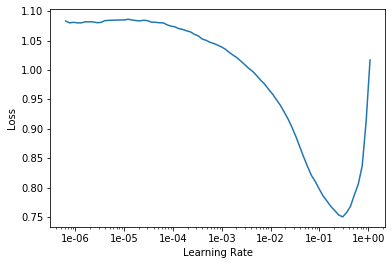

In [37]:
learn.recorder.plot()

In [38]:
data.c

17

In [0]:
lr = 0.01

In [40]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.137646,0.114561,0.942281,0.899580,03:38
1,0.113787,0.101311,0.950979,0.912076,03:37
2,0.103213,0.092539,0.950855,0.918464,03:36
3,0.096081,0.088845,0.952287,0.922380,03:38
4,0.091932,0.087686,0.955819,0.923465,03:39


In [0]:
learn.save('stage-1-rn50')

# Fine tune

In [0]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


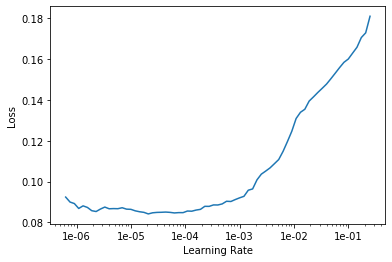

In [43]:
learn.lr_find()
learn.recorder.plot()

In [44]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.095307,0.091686,0.953007,0.918280,04:30
1,0.098631,0.090198,0.953821,0.921919,04:31
2,0.090050,0.084974,0.956182,0.926504,04:31
3,0.085423,0.082929,0.957897,0.928047,04:31
4,0.080287,0.082646,0.958507,0.929434,04:31


In [0]:
learn.save('stage-2-rn50')

# Transfer
- from prev model treained on 128
- to new on 256

In [48]:
data = (src.transform(tfms, size = 256)
.databunch().normalize(imagenet_stats)
)

learn.data = data
data.train_ds[0][0].shape

torch.Size([3, 256, 256])

In [0]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


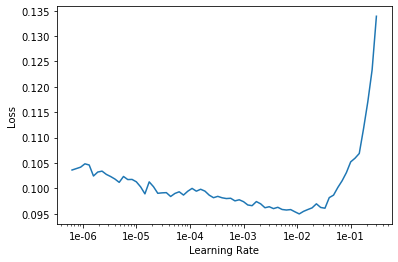

In [50]:
learn.lr_find()
learn.recorder.plot()

In [0]:
lr = 1e-2/2

In [54]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.102333,0.098405,0.952520,0.915731,14:35
1,0.102651,0.099080,0.949010,0.916116,14:24
2,0.096192,0.090335,0.953377,0.920600,14:22
3,0.091337,0.082846,0.957730,0.928283,14:22
4,0.084068,0.081723,0.958369,0.929751,14:15


In [0]:
learn.save('stage-1-256-rn50')

In [0]:
learn.unfreeze()

In [58]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.083742,0.081202,0.958457,0.930121,14:09
1,0.083120,0.082037,0.957999,0.929105,14:12
2,0.082163,0.081421,0.959285,0.929978,14:13
3,0.081686,0.080655,0.958696,0.930160,14:11
4,0.077145,0.080546,0.959387,0.930648,14:13


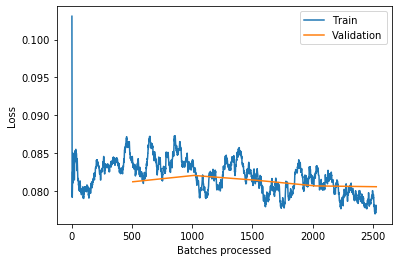

In [59]:
learn.recorder.plot_losses()

In [0]:
learn.save('stage-2-256-rn50')